In [21]:

import c3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import pickle

task_names = [
    'N-Pose Calibration',
    'Elbow Flexion Calibration',
    'Elbow Protation Calibration',
    'Wrist Flexion Calibration',
    'Wrist Deviation Calibration',
    'Shoulder Rotation Calibration',
    'Shoulder Flexion  Calibration',
    'Shoulder Abduction Calibration',
    'Scapula Elevation Calibration',
    'Scapula Protraction Calibration',
    'Elbow Flexion Task',
    'Elbow Pronation Task',
    'Shoulder Flexion Task',
    'Shoulder Abduction Task',
    'Shoulder Rotation Task',
    'Wrist Flexion Task',
    'Wrist Deviation Task',
    'Drinking Task',
    'Box Off Shelf Task',
    'Drawing Circles Task'  
]



def extract_c3d_points_position(c3d_reader):
    marker_names = c3d_reader.point_labels
    # frame_number is the number of frames
    # data is the 35 optical markers data (only take first three columns)
    
    marker_dict = {} # Create a dictionary with all marker data
    for marker in marker_names:
        marker_dict[marker] = []

    for frame_number, frame_data, _ in c3d_reader.read_frames():
        
        for marker in range(len(marker_names)):
            marker_dict[marker_names[marker]].append(frame_data[marker, :3])
            
    for marker in marker_names:
        marker_dict[marker] = np.asanyarray(marker_dict[marker])
        
    return marker_dict, marker_names

def rotate_axes(marker_dict):
    
    marker_names = list(marker_dict.keys())
    marker_dict_rotated = {}
    for marker in marker_names:
        marker_dict_rotated[marker] = np.stack([marker_dict[marker][:,1], marker_dict[marker][:,2], marker_dict[marker][:,0]], axis=1)
        
    return marker_dict_rotated

####### Compute Segment reference Frames #####

def compute_thorax_reference_frame(marker_dict):
    # From (Wu et al. 2005)
    qG_TH = []
    for frame in range(len(marker_dict['C7  '])):
        IJ = marker_dict['IJ  '][frame,:]
        C7 = marker_dict['C7  '][frame,:]
        T8 = marker_dict['T8  '][frame,:]
        PX = marker_dict['PX  '][frame,:]

        Origin = IJ
        # The line connecting the midpoint between PX and T8 and the midpoint 
        # between IJ and C7, pointing upward
        C7IJmid = (C7 + IJ)/2
        PXT8mid = (PX + T8)/2
        # Y = (C7IJmid - PXT8mid)/np.linalg.norm((C7IJmid - PXT8mid),ord='fro')
        Y = (C7IJmid - PXT8mid)/np.linalg.norm((C7IJmid - PXT8mid))
        # Z: The line perpendicular to the plane formed by IJ, C7, and the 
        # midpoint between PX and T8, pointing to the right
        IJ, PXT8mid, C7
        Z = np.cross( IJ-PXT8mid, C7-PXT8mid )/np.linalg.norm(np.cross( IJ-PXT8mid, C7-PXT8mid ))
        X = np.cross(Y,Z)/np.linalg.norm(np.cross(Y,Z))
        TH = R.from_matrix([X,Y,Z])
        qG_TH.append(TH.inv().as_quat())
        
    return R.from_quat(np.asanyarray(qG_TH))
 
 
def compute_upper_arm_reference_frame(marker_dict):
    # From (Wu et al. 2005) -- Use H1 frame
    qG_UA = []
    for frame in range(len(marker_dict['C7  '])):
        GHJC = marker_dict['GHJC'][frame,:]
        EL = marker_dict['EL  '][frame,:]
        EM = marker_dict['EM  '][frame,:]
        Origin = GHJC
        ELEMmid = (EL + EM)/2
        X_temp = np.cross(EL-GHJC, EM-GHJC)
        
        Y = (GHJC - ELEMmid)/np.linalg.norm(GHJC - ELEMmid)
        Z = np.cross(X_temp, Y)/np.linalg.norm(np.cross(X_temp, Y))
        X = np.cross(Y, Z)/np.linalg.norm(np.cross(Y, Z))
        
        UA = R.from_matrix([X,Y,Z])
        qG_UA.append(UA.inv().as_quat())
    
    return R.from_quat(np.asanyarray(qG_UA))

def compute_lower_arm_reference_frame(marker_dict):
    # From (Wu et al. 2005)
    qG_LA = []
    for frame in range(len(marker_dict['C7  '])):
        EL = marker_dict['EL  '][frame,:]
        EM = marker_dict['EM  '][frame,:]
        US = marker_dict['US  '][frame,:]
        RS = marker_dict['RS  '][frame,:]
        Origin = US

        ELEMmid = (EL + EM)/2
  
        Z_temp = np.cross(US-ELEMmid, RS-ELEMmid)
        
        Y = ELEMmid-US
        X = np.cross(Y,Z_temp)/np.linalg.norm(np.cross(Y,Z_temp))
        Y = Y/np.linalg.norm(Y)
        Z = np.cross(X,Y)/np.linalg.norm(np.cross(X,Y))
           
        LA = R.from_matrix([X,Y,Z])
        qG_LA.append(LA.inv().as_quat())
    
    return R.from_quat(np.asanyarray(qG_LA))
        
def compute_hand_reference_frame(marker_dict):

    qG_HA = []
    for frame in range(len(marker_dict['C7  '])):
        
        US = marker_dict['US  '][frame,:]
        RS = marker_dict['RS  '][frame,:]
        MCP2 = marker_dict['MCP2'][frame,:]
        MCP3 = marker_dict['MCP3'][frame,:]
        MCP5 = marker_dict['MCP5'][frame,:]

        USRSmid = (US + RS)/2
        temp = MCP2-MCP5
        
        Y = USRSmid - MCP3
        Z = np.cross(temp, Y)/np.linalg.norm(np.cross(temp, Y))
        Y = Y/np.linalg.norm(Y)
        X = np.cross(Y,Z)/np.linalg.norm(np.cross(Y,Z))
          
        HA = R.from_matrix([X,Y,Z])
        qG_HA.append(HA.inv().as_quat())
    
    return R.from_quat(np.asanyarray(qG_HA))  



In [23]:

path = '..\\Sample Data\\OPTO'
file_list = os.listdir(path)
Joint_Angles_dict = {}
Segment_Angles_dict = {}
for idx in range(10,len(task_names)):

    Segment_Angles_dict[idx-10] = {
        'Task Name': '',
        'Thorax': [],
        'Right Upper Arm': [],
        'Right Lower Arm': [],
        'Right Hand': []
    }

    Joint_Angles_dict[idx-10] = {
        'Task Name': '',
        'Right Shoulder': [],
        'Right Elbow': [],
        'Right Wrist': []
    }
    file = file_list[idx]

    c3d_reader = c3d.Reader(open(os.path.join(path, file), 'rb'))
    marker_dict, marker_names = extract_c3d_points_position(c3d_reader)
    # marker_dict = rotate_axes(marker_dict)

    G_TH = compute_thorax_reference_frame(marker_dict) 
    G_UA = compute_upper_arm_reference_frame(marker_dict)
    G_LA = compute_lower_arm_reference_frame(marker_dict)
    G_HA = compute_hand_reference_frame(marker_dict)
    
    Segment_Angles_dict[idx-10]['Task Name'] = task_names[idx]
    Segment_Angles_dict[idx-10]['Thorax'] = G_TH
    Segment_Angles_dict[idx-10]['Right Upper Arm'] = G_UA
    Segment_Angles_dict[idx-10]['Right Lower Arm'] = G_LA
    Segment_Angles_dict[idx-10]['Right Hand'] = G_HA
    
    right_shoulder = G_TH.inv() * G_UA
    right_elbow = G_UA.inv() * G_LA
    right_wrist = G_LA.inv() * G_HA
    
    # Convert to euler angles
    if idx == 13:
        sequence = 'XYZ'
    elif idx == 15 or idx == 16:
        sequence = 'ZYX'
    else:
        sequence = 'ZXY'
        
    right_shoulder_euler = right_shoulder.as_euler(sequence)*180/np.pi
    right_elbow_euler = right_elbow.as_euler(sequence)*180/np.pi
    right_wrist_euler = right_wrist.as_euler(sequence)*180/np.pi
    
    #fix inconsistencies in joint angles
    if idx == 13:
        right_shoulder_euler[:,0] = -right_shoulder_euler[:,0]
        
    if idx == 14:
        right_shoulder_euler = np.array([right_shoulder_euler[:,0], right_shoulder_euler[:,2], right_shoulder_euler[:,1]]).transpose()
        
    right_wrist_euler = np.array([right_wrist_euler[:,2], right_wrist_euler[:,1], right_wrist_euler[:,0]]).transpose()
    
    #Save joint angles in a dictionary    
    Joint_Angles_dict[idx-10]['Task Name'] = task_names[idx]
    Joint_Angles_dict[idx-10]['Right Shoulder'] = right_shoulder_euler
    Joint_Angles_dict[idx-10]['Right Elbow'] = right_elbow_euler
    Joint_Angles_dict[idx-10]['Right Wrist'] = right_wrist_euler
    with open('3.OPTO_Joint_Angles.pkl', 'wb') as f:
        pickle.dump(Joint_Angles_dict, f)


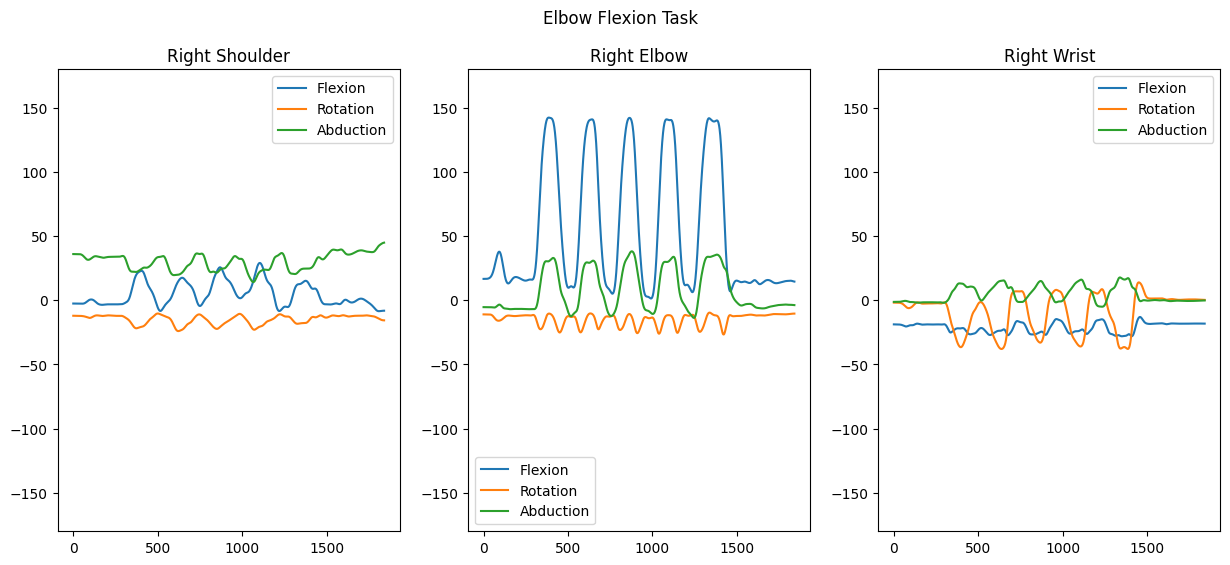

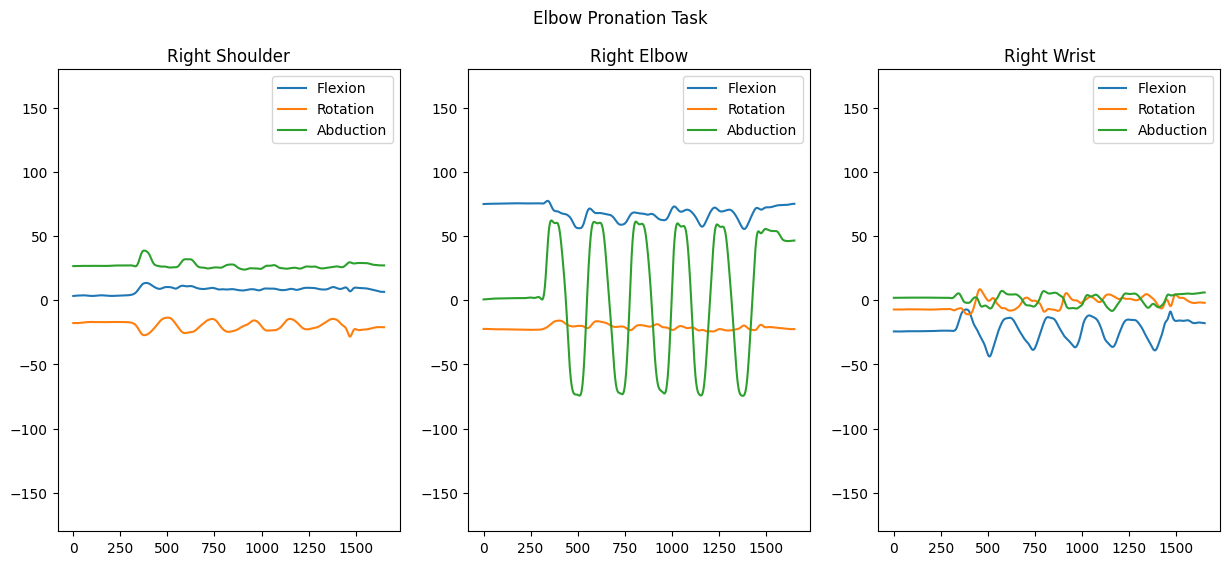

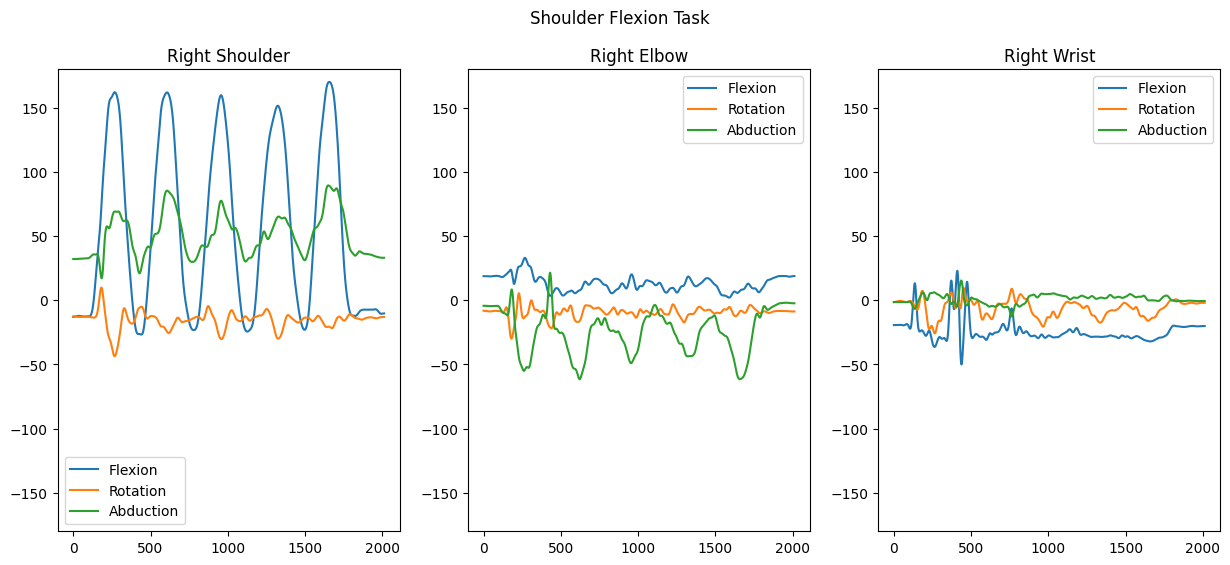

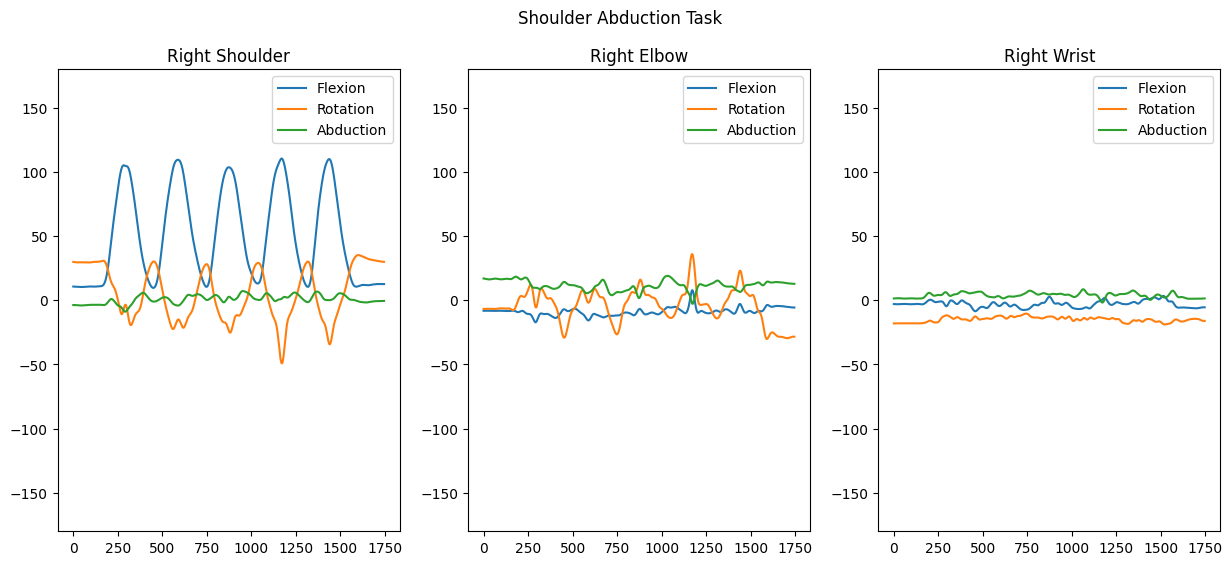

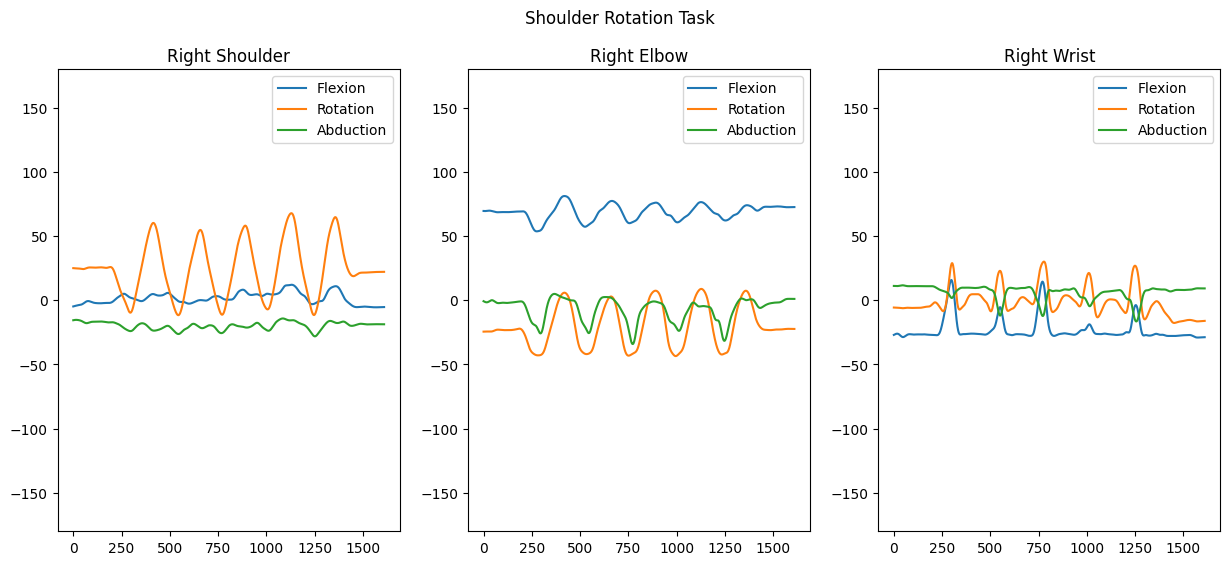

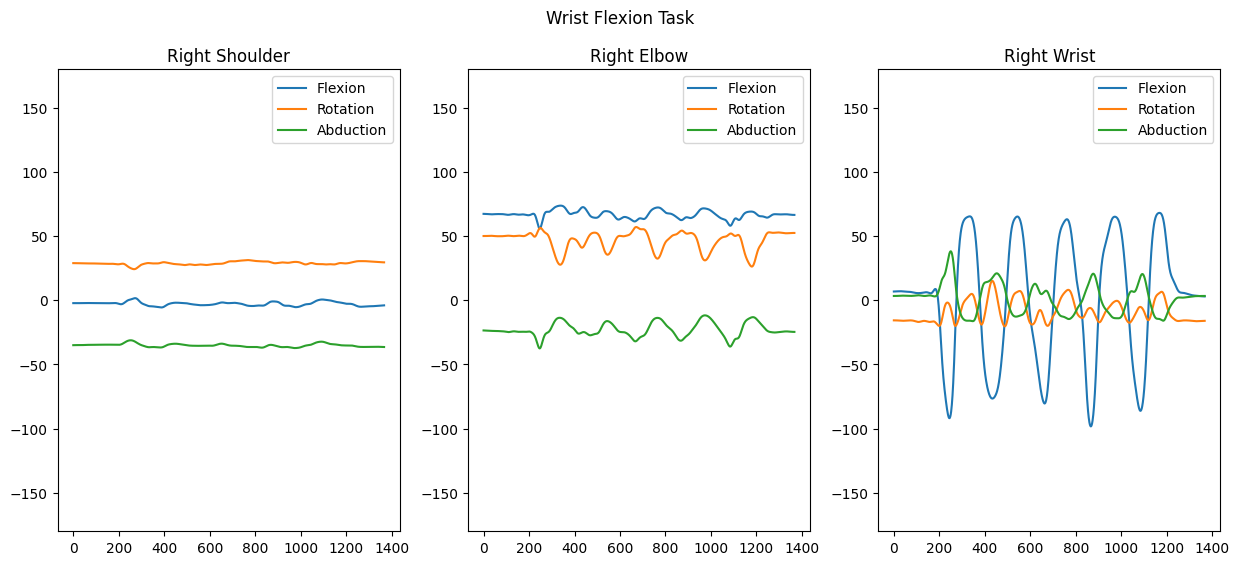

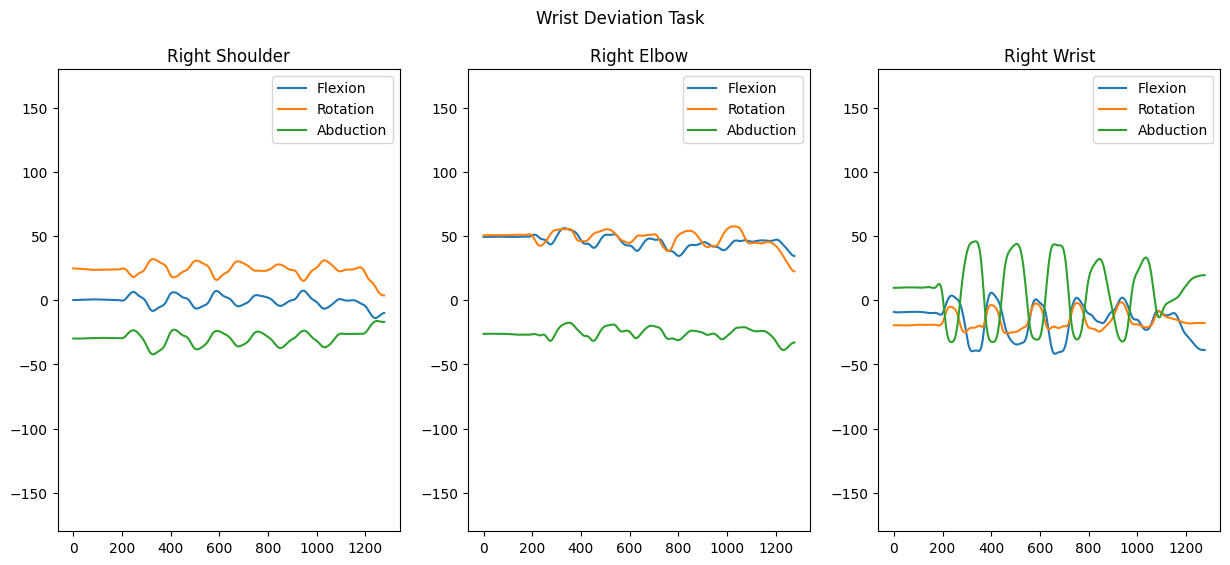

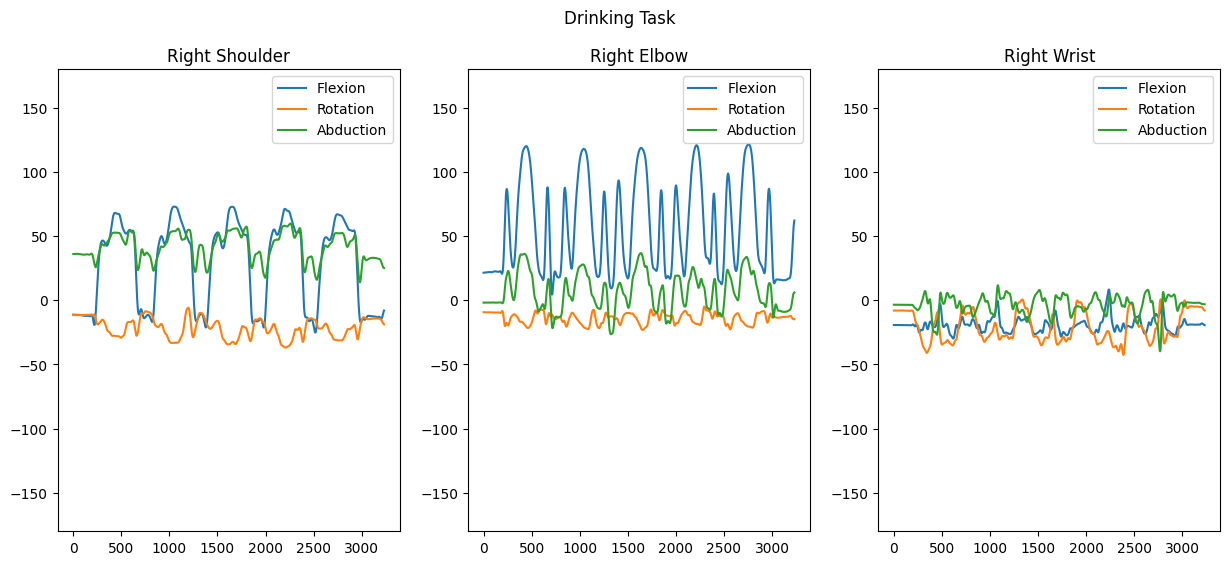

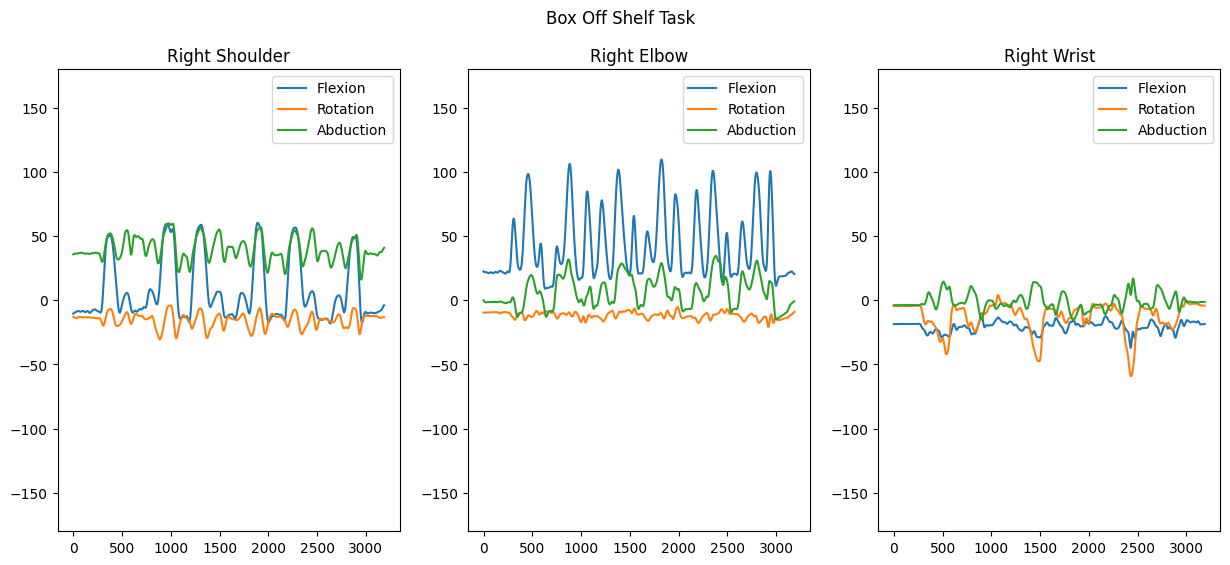

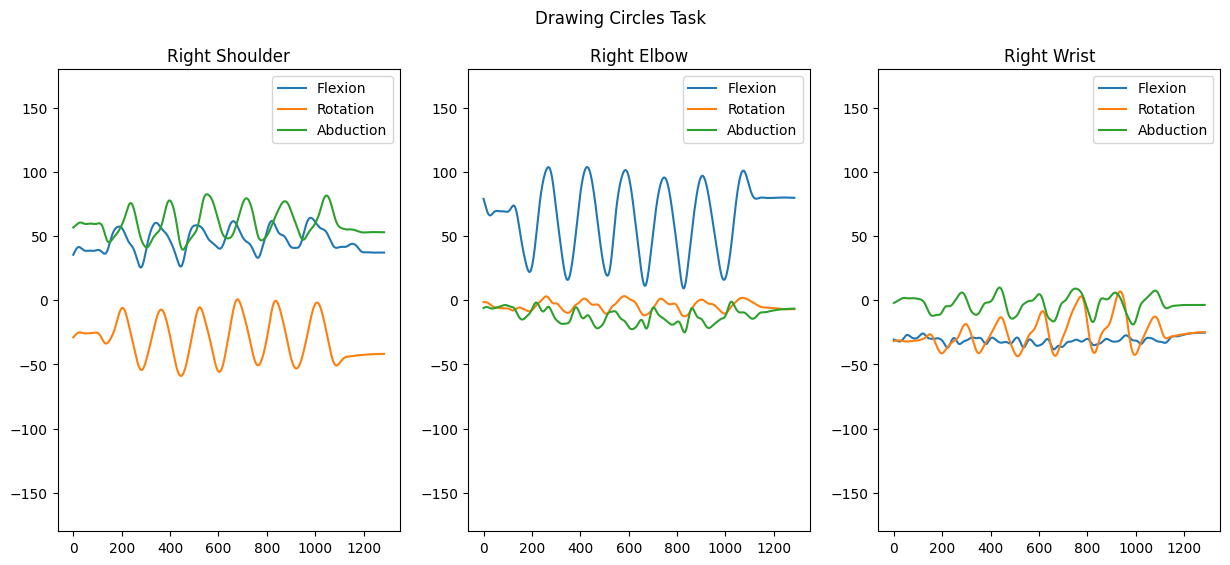

In [20]:
# segments = ['Thorax', 'Right Upper Arm', 'Right Lower Arm', 'Right Hand']
# sequence = 'XYZ'
# for task in range(len(Joint_Angles_dict)):
#     fig.suptitle(Joint_Angles_dict[task]['Task Name'])
#     fig, axList = plt.subplots(1,4, figsize=(15,6))
#     for s in range(len(segments)):
#         axList[s].set_title(segments[s])
#         axList[s].plot(Segment_Angles_dict[task][segments[s]].as_euler(sequence)*180/3.14)
#         axList[s].legend(['Flexion','Rotation', 'Abduction'])
#         axList[s].set_ylim(-180, 180)


joints = ['Right Shoulder', 'Right Elbow', 'Right Wrist']

for task in range(len(Joint_Angles_dict)):
    fig, axList = plt.subplots(1,3, figsize=(15,6))
    fig.suptitle(Joint_Angles_dict[task]['Task Name'])
    
    # if task == 3:
    #     sequence = 'XYZ'
    # elif task == 5 or task == 6:
    #     sequence = 'ZYX'
    # else:
    #     sequence = 'ZXY'
    
    for j in range(len(joints)):
        joint = joints[j]
        axList[j].set_title(joint)
        axList[j].plot(Joint_Angles_dict[task][joint])
        axList[j].legend(['Flexion','Rotation', 'Abduction'])
        axList[j].set_ylim(-180, 180)